Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи

ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ

ab_products – подробная информация о продуктах, их название и стоимость

NB! Не стоит использовать интерактивные графики в итоговом файле – они имеют смысл только в динамических отчётах вроде веб-страницы.

В поле ответа прикрепите файл формата .ipynb — то есть обычный Jupyter Notebook со всеми вашими действиями, результатами, графиками и выводами.

In [1]:
import json
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats
import math
import pingouin as pg
from scipy.stats import chi2_contingency, chi2
from statistics import variance, pvariance
# Font size will be increased, background of figures will be white, grid will be present and size of plots will be increased

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [2]:
# Загрузим и предобработаем данные
ab_users_data = pd.read_csv('ab_users_data.csv', parse_dates=['time', 'date'])
ab_orders = pd.read_csv('ab_orders.csv', parse_dates=['creation_time'])
ab_products = pd.read_csv('ab_products.csv')

In [3]:
# Посмотрим на все данные
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [4]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [5]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


Посчитаем 4 метрики, основываясь на них оценим эффективность системы рекомендаций
1. Средний чек на пользователя 
2. % отменённых заказов на пользователя 
3. Количество выполненых заказов на пользователя 
4. Уникальные товары на пользователя

In [6]:
# Сравним кол-во уникальных пользователей в группах
ab_users_data.groupby(['group']) \
    .agg({'user_id': 'nunique'})

,user_id
group,
0,515
1,502


In [7]:
# Посмотрим на кол-во сделанных и отмененных заказов в группах
ab_users_data.groupby(['action', 'group']) \
    .agg({'order_id': 'count'})

order_id
action       group          
cancel_order 0            82
             1           132
create_order 0          1609
             1          2514

In [8]:
# Кол-во действий по дням
ab_users_data.value_counts('date')

date
2022-08-26    1384
2022-08-29     366
2022-08-27     323
2022-08-28     313
2022-08-30     271
2022-09-04     240
2022-09-03     232
2022-09-01     228
2022-09-02     228
2022-08-31     201
2022-09-07     160
2022-09-08     138
2022-09-05     130
2022-09-06     123
Name: count, dtype: int64

In [9]:
ab_users_data.date.nunique()

14

In [10]:
# Хочу упростить наименование дней для будущего графика.
ab_users_data.date.unique()

<DatetimeArray>
['2022-08-26 00:00:00', '2022-08-27 00:00:00', '2022-08-28 00:00:00',
 '2022-08-29 00:00:00', '2022-08-30 00:00:00', '2022-08-31 00:00:00',
 '2022-09-01 00:00:00', '2022-09-02 00:00:00', '2022-09-03 00:00:00',
 '2022-09-04 00:00:00', '2022-09-05 00:00:00', '2022-09-06 00:00:00',
 '2022-09-07 00:00:00', '2022-09-08 00:00:00']
Length: 14, dtype: datetime64[ns]

In [11]:
[x.strftime('%d.%m') for x in ab_users_data.date.unique()]

['26.08',
 '27.08',
 '28.08',
 '29.08',
 '30.08',
 '31.08',
 '01.09',
 '02.09',
 '03.09',
 '04.09',
 '05.09',
 '06.09',
 '07.09',
 '08.09']

[Text(19230.0, 0, '26.08'),
 Text(19231.0, 0, '27.08'),
 Text(19232.0, 0, '28.08'),
 Text(19233.0, 0, '29.08'),
 Text(19234.0, 0, '30.08'),
 Text(19235.0, 0, '31.08'),
 Text(19236.0, 0, '01.09'),
 Text(19237.0, 0, '02.09'),
 Text(19238.0, 0, '03.09'),
 Text(19239.0, 0, '04.09'),
 Text(19240.0, 0, '05.09'),
 Text(19241.0, 0, '06.09'),
 Text(19242.0, 0, '07.09'),
 Text(19243.0, 0, '08.09')]

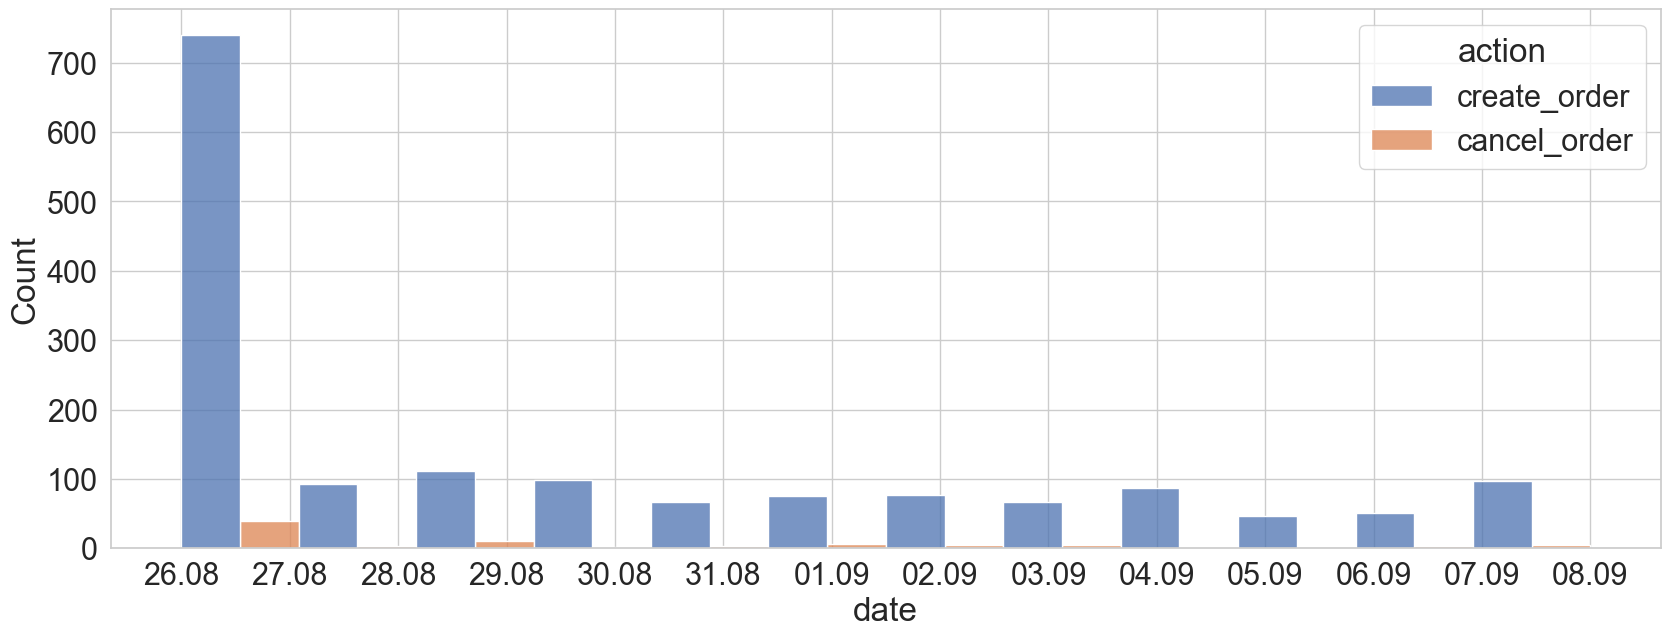

In [12]:
# Посмотрим на колличество сделанных и отмененных заказов по дням для каждой группы. Для дальнейших расчетов не понадобится, но оставил для общей информации. 
g = sns.histplot(ab_users_data[ab_users_data.group == 0], x='date', hue='action', multiple='dodge')
g.set_xticks(ab_users_data.date.unique()) # <--- set the ticks first
g.set_xticklabels([x.strftime('%d.%m') for x in ab_users_data.date.unique()])

[Text(19230.0, 0, '26.08'),
 Text(19231.0, 0, '27.08'),
 Text(19232.0, 0, '28.08'),
 Text(19233.0, 0, '29.08'),
 Text(19234.0, 0, '30.08'),
 Text(19235.0, 0, '31.08'),
 Text(19236.0, 0, '01.09'),
 Text(19237.0, 0, '02.09'),
 Text(19238.0, 0, '03.09'),
 Text(19239.0, 0, '04.09'),
 Text(19240.0, 0, '05.09'),
 Text(19241.0, 0, '06.09'),
 Text(19242.0, 0, '07.09'),
 Text(19243.0, 0, '08.09')]

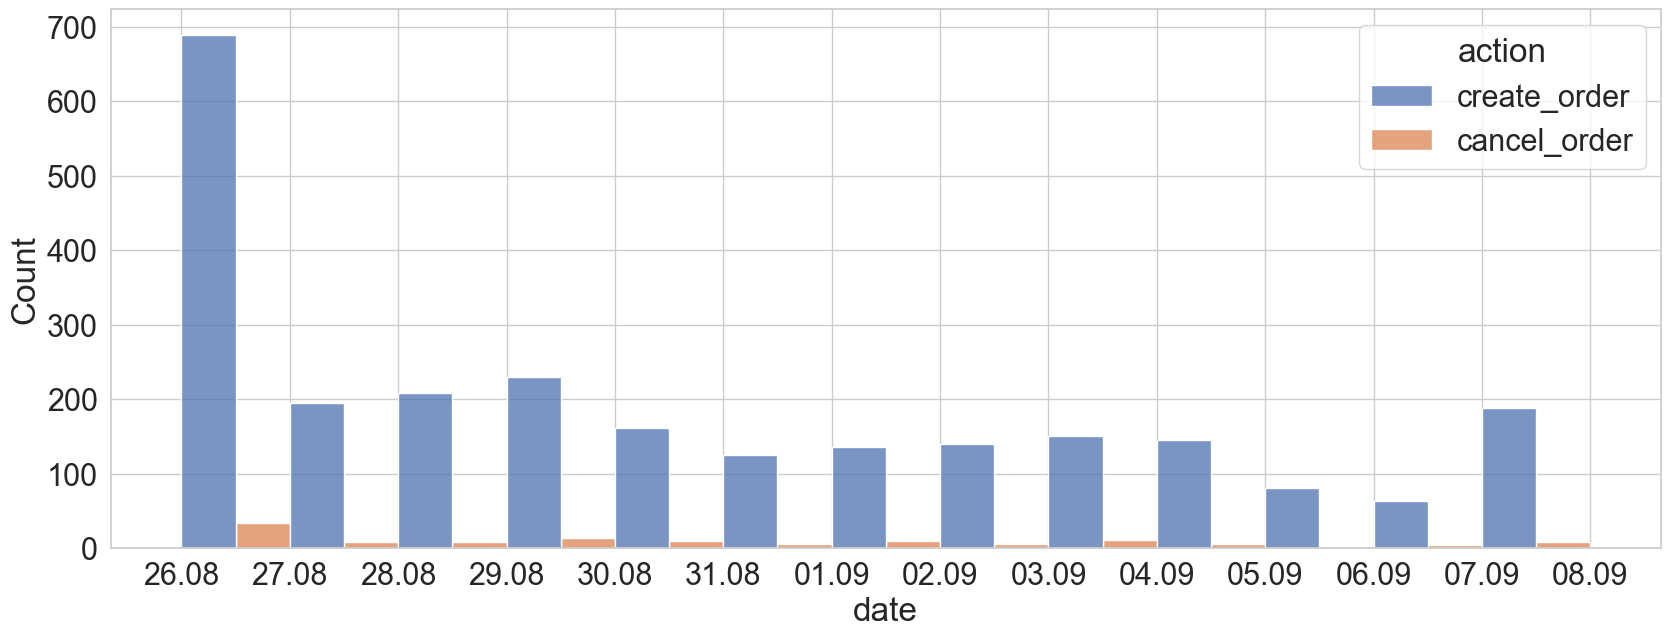

In [13]:
# Посмотрев на обаграфика можно, наглядно заметить что Отменяли заказы в обеих группах примерно одинаково.
# Но вот если в первый день в группе 0 и 1 сделао одинаковое кол-во заказов, то далее уже каждый день есть различия.
g = sns.histplot(ab_users_data[ab_users_data.group == 1], x='date', hue='action', multiple='dodge')
g.set_xticks(ab_users_data.date.unique()) # <--- set the ticks first
g.set_xticklabels([x.strftime('%d.%m') for x in ab_users_data.date.unique()])

In [14]:
# Теперь 'вытащим' наименования товаров.
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [15]:
ab_orders.product_ids.values[0].replace('{', '[').replace('}', ']')

'[75, 22, 53, 84]'

In [16]:
json.loads(ab_orders.product_ids.values[0].replace('{', '[').replace('}', ']'))

[75, 22, 53, 84]

In [17]:
ab_orders['product_ids'] = ab_orders.product_ids.apply(lambda x: json.loads(x.replace('{', '[').replace('}', ']')))

In [18]:
# запишем в новый датафрейм список товаров в заказе
ab_orders_re = ab_orders.explode('product_ids')

In [19]:
ab_orders_re

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,75
0,1255,2022-08-26 00:00:19,22
0,1255,2022-08-26 00:00:19,53
0,1255,2022-08-26 00:00:19,84
1,1256,2022-08-26 00:02:21,56
...,...,...,...
4121,59487,2022-09-08 23:29:06,9
4121,59487,2022-09-08 23:29:06,62
4121,59487,2022-09-08 23:29:06,77
4122,59533,2022-09-08 23:41:24,17


In [20]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [21]:
# Объединим таблицы истории заказов пользователей и информации о составе заказа
ab_users_data_re = ab_users_data.merge(ab_orders_re, on='order_id', how='right')

## 1. Средний чек.

In [22]:
# Найдем Id отменынх заказов
cancel_orders = ab_users_data_re[ab_users_data_re.action == 'cancel_order'].order_id

In [23]:
# Уберем отмененые заказы из датафрейма
done_orders = ab_users_data_re[~ab_users_data_re.order_id.isin(cancel_orders)].rename(columns={"product_ids": 'product_id'})
done_orders

,user_id,order_id,action,time,date,group,creation_time,product_id
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56
...,...,...,...,...,...,...,...,...
14564,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,9
14565,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,62
14566,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,77
14567,1376,59533,create_order,2022-09-08 23:41:24,2022-09-08,0,2022-09-08 23:41:24,17


In [24]:
# Добавим таблицу с ценой товара, для подсчета среднего чека
done_orders = done_orders.merge(ab_products, on='product_id', how='left')
done_orders

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56,сосиски,150.0
...,...,...,...,...,...,...,...,...,...,...
13078,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,9,чай черный листовой,83.5
13079,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,62,сок яблочный,120.0
13080,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,77,курица,298.4
13081,1376,59533,create_order,2022-09-08 23:41:24,2022-09-08,0,2022-09-08 23:41:24,17,морс брусничный,190.0


In [25]:
# сгруппируем сумму товаров и заказов на покупателя. 
average_bill_by_users = done_orders.groupby(['group', 'user_id'], as_index=False) \
                          .agg({'price': 'sum', 'order_id': 'nunique'})

In [26]:
# Посчитаем сколько в среднем пользователь тратил на заказ и создадим колонку с этим значением 
average_bill_by_users['average_bill'] = average_bill_by_users['price'] / average_bill_by_users['order_id']
average_bill_by_users

,group,user_id,price,order_id,average_bill
0,0,964,718.9,2,359.450000
1,0,968,1590.7,3,530.233333
2,0,969,681.9,2,340.950000
3,0,972,546.4,1,546.400000
4,0,975,1432.9,2,716.450000
...,...,...,...,...,...
1008,1,1976,2001.9,5,400.380000
1009,1,1977,781.2,4,195.300000
1010,1,1978,2276.3,6,379.383333
1011,1,1979,1907.1,5,381.420000


In [27]:
# Собствеено сам средний чек на группу.
average_bill_by_users.groupby('group').agg({'average_bill': 'mean'})

,average_bill
group,
0,386.039053
1,371.203622


In [28]:
# Используем Welch’s t-test. H0 - у пользователей из групп 0 и 1 в средние чеки одинаковы. H1 у пользователей из групп 0 и 1 в средние чеки не одинаковы .
# Т.к. pvalue=0.12264464021798567 > 0.05 принимаем H0. 
# У нас не достаточно доказательств сказать, что у пользователей из групп 0 и 1 чеки различаются.
stats.ttest_ind(average_bill_by_users.loc[average_bill_by_users.group == 0, 'average_bill'], average_bill_by_users.loc[average_bill_by_users.group == 1, 'average_bill'], equal_var=False)

TtestResult(statistic=1.5451367735756034, pvalue=0.12264464021798567, df=954.5240709776994)

<Axes: xlabel='average_bill', ylabel='Count'>

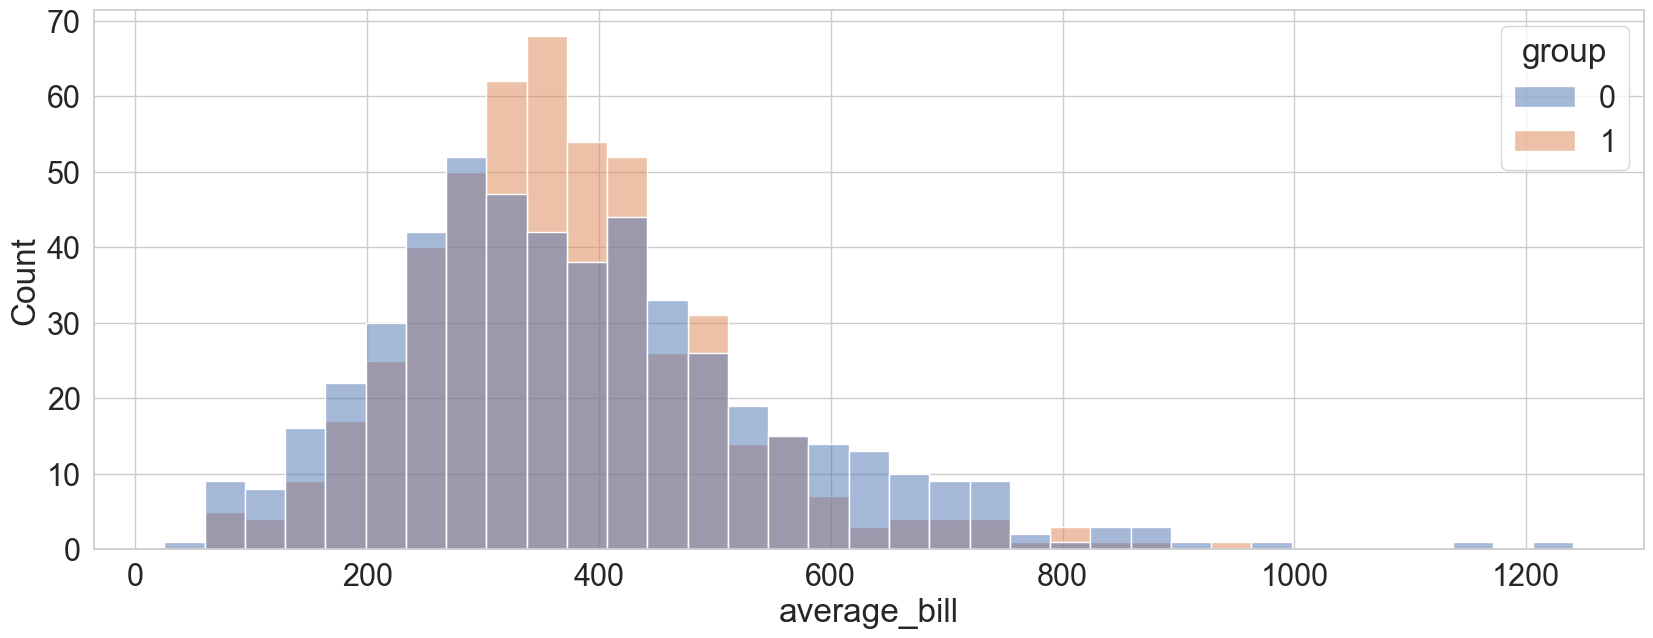

In [29]:
# График подтвержает расчеты, в среднем затраты покупателей примерно одинаковые.
sns.histplot(average_bill_by_users[['average_bill', 'group']], x="average_bill", hue="group")

## 2. % отменённых заказов на пользователя 

In [30]:
# Продублируем значения из колонки action только в цифровом формате 0-создан заказ, 1- отменен, выбраны именно 1 для отмены(так будет удобнее посчитать)
cancel_orders = ab_users_data
cancel_orders['is_cancel'] = cancel_orders['action'].map({'create_order': 0, 'cancel_order': 1})
cancel_orders

,user_id,order_id,action,time,date,group,is_cancel
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,0
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,0
...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,0
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,0
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,0
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,0


In [31]:
# Посчитаем среднее кол-во отмен на пользователя.
cancel_orders = cancel_orders.groupby(['group', 'user_id'], as_index=False) \
                             .agg({'is_cancel': 'mean'})
cancel_orders

,group,user_id,is_cancel
0,0,964,0.000000
1,0,966,0.500000
2,0,968,0.000000
3,0,969,0.000000
4,0,972,0.000000
...,...,...,...
1012,1,1976,0.000000
1013,1,1977,0.000000
1014,1,1978,0.125000
1015,1,1979,0.142857


In [32]:
# Используем Welch’s t-test. H0 - пользователи из групп 0 и 1 в среднем одинаково отменяли заказы. H1 пользователи из групп 0 и 1 в среднем не одинаково отменяли заказы.\
# Т.к. pvalue=0.4442252383053865 > 0.05 принимаем H0. 
# У нас не достаточно доказательств сказать, что пользователи из групп 0 и 1 в среднем не одинаково отменяли заказы.
stats.ttest_ind(cancel_orders.loc[cancel_orders.group == 0, 'is_cancel'], cancel_orders.loc[cancel_orders.group == 1, 'is_cancel'], equal_var=False)

TtestResult(statistic=-0.7653806437776364, pvalue=0.4442252383053865, df=1001.527733810655)

<Axes: xlabel='is_cancel', ylabel='Count'>

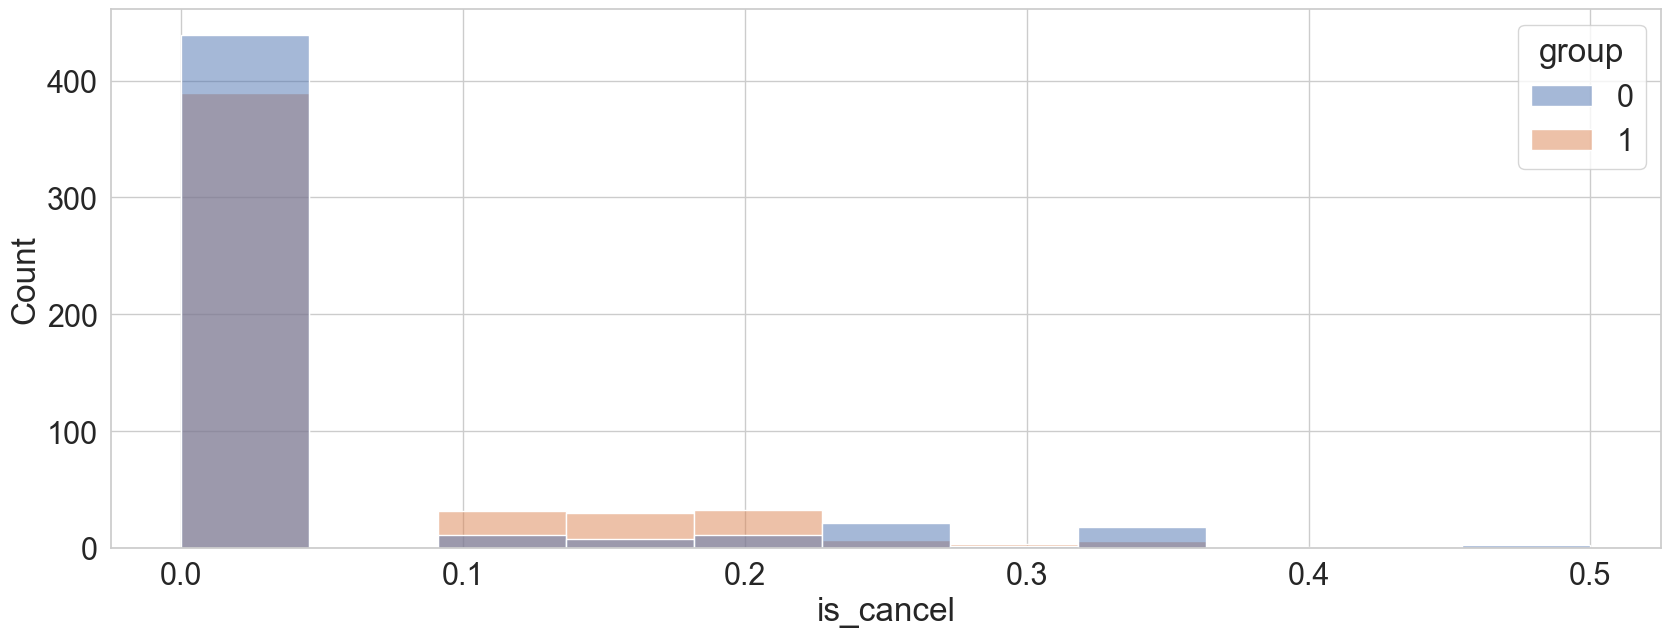

In [33]:
# График подтверждает тест, видно что значения отличаются не значительно.
sns.histplot(cancel_orders[['is_cancel', 'group']], x="is_cancel", hue="group")

## 3. Количество выполненых заказов на пользователя

In [34]:
# сгруппируем кол-во заказов на пользователя по группам
done_orders_by_users = done_orders.groupby(['group', 'user_id'], as_index=False) \
                                  .agg({'order_id': 'nunique'})
done_orders_by_users

,group,user_id,order_id
0,0,964,2
1,0,968,3
2,0,969,2
3,0,972,1
4,0,975,2
...,...,...,...
1008,1,1976,5
1009,1,1977,4
1010,1,1978,6
1011,1,1979,5


In [35]:
# Посчитаем сколько в среднем совершал заказов пользователь в группе(понадобится для вывода)
done_orders_by_users.groupby(['group'], as_index=False) \
                                  .agg({'order_id': 'mean'})

,group,order_id
0,0,2.982422
1,1,4.754491


In [36]:
4.754491-2.982422

1.7720689999999997

In [37]:
# Используем Welch’s t-test. H0 - пользователи из групп 0 и 1 в среднем совершали одинаковые кол-ва заказов. H1 пользователи из групп 0 и 1 в среднем совершали разные кол-ва заказов.\
# Т.к. pvalue=1.2374101233656574e-40 < 0.05 отвергаем H0. 
# У нас не достаточно доказательств сказать, что пользователи из групп 0 и 1 в среднем совершали одинаковые кол-ва заказов.
stats.ttest_ind(done_orders_by_users.loc[done_orders_by_users.group == 0, 'order_id'], done_orders_by_users.loc[done_orders_by_users.group == 1, 'order_id'], equal_var=False)

TtestResult(statistic=-13.974169980221783, pvalue=1.2374101233656574e-40, df=989.8228352282781)

<Axes: xlabel='order_id', ylabel='Count'>

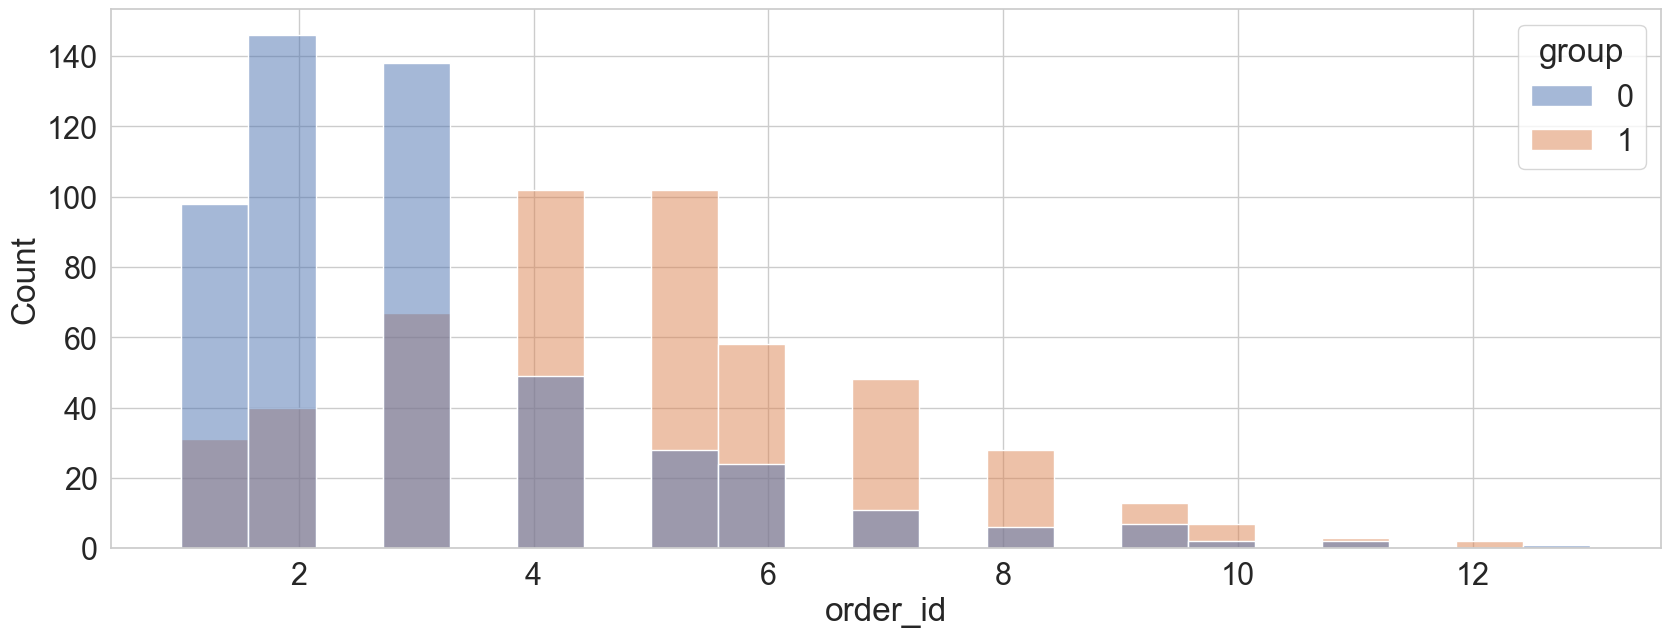

In [38]:
# График подтверждает наш проведенный тест и дополнительно показывает, что в 1 группе в среднем совершалось больше заказов(на 1.77шт в среднем)
sns.histplot(done_orders_by_users[['order_id', 'group']], x="order_id", hue="group")

## 4. Уникальные товары на пользователя

In [39]:
ab_users_data_re

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56
...,...,...,...,...,...,...,...,...
14564,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,9
14565,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,62
14566,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,77
14567,1376,59533,create_order,2022-09-08 23:41:24,2022-09-08,0,2022-09-08 23:41:24,17


In [40]:
# Посчитаем кол-во уникальных товаров на пользователя 
ab_product_nunique = ab_users_data_re.groupby(['group', 'user_id'], as_index=False).agg({'product_ids': 'nunique'})
ab_product_nunique

,group,user_id,product_ids
0,0,964,8
1,0,966,2
2,0,968,11
3,0,969,8
4,0,972,5
...,...,...,...
1012,1,1976,15
1013,1,1977,9
1014,1,1978,16
1015,1,1979,22


In [41]:
# Используем Welch’s t-test. H0 - пользователи из групп 0 и 1 в среднем выбирают одинаковые кол-ва наименований товаров. H1 пользователи из групп 0 и 1 в среднем выбирают разные кол-ва наименований товаров.\
# Т.к. pvalue=1.2896800867613944e-41 < 0.05 отвергаем H0. 
# У нас не достаточно доказательств сказать, что пользователи из групп 0 и 1 в среднем выбирают одинаковые кол-ва наименований товаров.
stats.ttest_ind(ab_product_nunique.loc[ab_product_nunique.group == 0, 'product_ids'], ab_product_nunique.loc[ab_product_nunique.group == 1, 'product_ids'], equal_var=False)

TtestResult(statistic=-14.163833715256525, pvalue=1.2896800867613944e-41, df=993.0946428921554)

<Axes: xlabel='product_ids', ylabel='Count'>

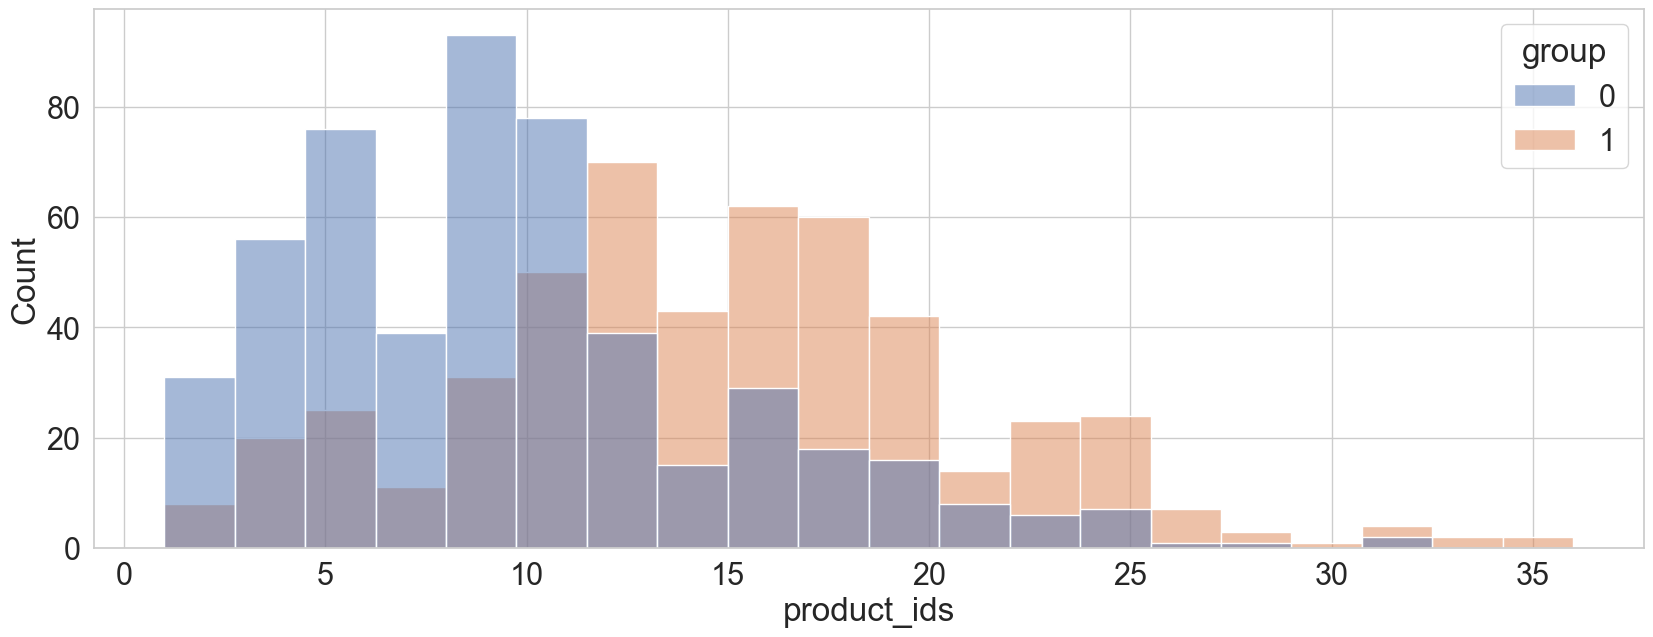

In [42]:
# По графику видно, что в 1 группе покупатели выбирают больше различных товаров
sns.histplot(ab_product_nunique[['product_ids', 'group']], x="product_ids", hue="group")

## Вывод
Проверили 4 метрики, получили, что средний чек на пользователя практически не изменился, как и % отменных заказов, но пользователи стали покупать более разнообразные наиенования товаров и совершать больше заказов. \
В общем система рекомендаций улучшила сервис. Если по цифрам то 1 группа в среднем за 14 дней на 657 у.е. больше приносит прибыли. 
Зная стоимость всех затрат на рекомендации, можно посчитать окончательно принимать или нет новый сервис.